In [1]:
"""\
# Copyright (C) 2023 Jesús Bautista Villar <jesbauti20@gmail.com>
- Testing a proportional 3D heading control algorithm -
"""

import os
import time
import numpy as np
from tqdm import tqdm

# -- Graphic tools --
import matplotlib.pyplot as plt

# -- Animation tools --
from matplotlib.animation import FuncAnimation, FFMpegWriter

# -- Our utils --
from simulations.utils.tools_math import *
from simulations.utils.tools_plot import *

from simulations.utils.tools_basic import createDir
from simulations.sim_test import sim_test


# Create the output directory
OUTPUT_FOLDER = os.path.join("output")
createDir(OUTPUT_FOLDER)

# ## WIP ##

"""\
"""

The directory 'output' already exists!


''

## Simulation frame to test the 3D heading controller

  0%|          | 0/721 [00:00<?, ?it/s]

100%|██████████| 721/721 [00:00<00:00, 1140.68it/s]


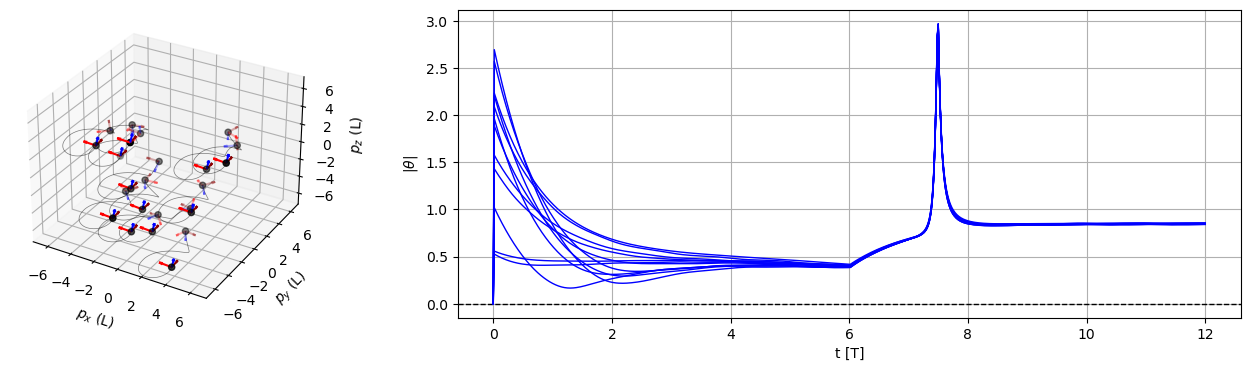

In [2]:
# Initialise the simulation frame and launch the numerical simulation
sim_frame = sim_test(n_agents=12, tf=12, wx=2*np.pi, L1=np.array([[1,-1,0]])/np.sqrt(2),
                      v_rotation=True, fb_control=True, sim_kw={"kw":1}, arr_len=1)
sim_frame.numerical_simulation()

# Plot the summary (initial + final state)
sim_frame.plot_summary()

Animation parameters:  {'fps': 60.0, 'tf': 3, 'frames': 179}


 98%|█████████▊| 176/179 [00:05<00:00, 31.95it/s]

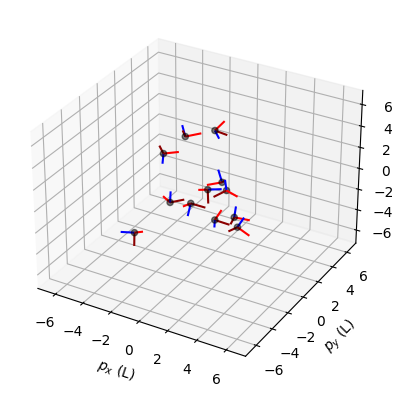

In [3]:
# Generate an animation of the whole simulation
sim_frame.generate_animation(OUTPUT_FOLDER)

## Plotting trajectories in $S0_3$

In [2]:
# Initialise the simulation frame and launch the numerical simulation
L1 = np.array([[1,0,0]])
sim_frame = sim_test(n_agents=10, tf=12, wx=np.pi/2, L1=L1/np.linalg.norm(L1),
                      v_rotation=False, fb_control=True, sim_kw={"kw":1}, arr_len=1)
sim_frame.numerical_simulation()

# Extract the desired data (R matrices)
data_R = sim_frame.data["R"]
print(data_R.shape)

  0%|          | 0/721 [00:00<?, ?it/s]

100%|██████████| 721/721 [00:00<00:00, 1320.16it/s]

(721, 10, 3, 3)


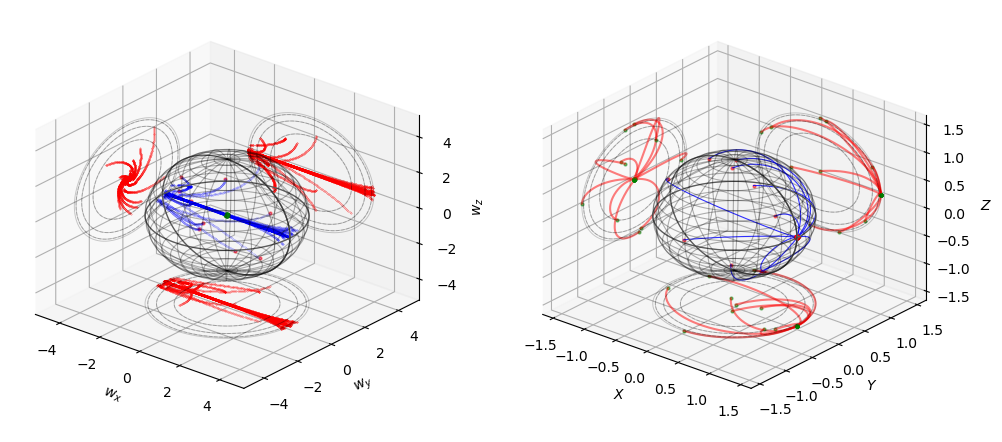

In [3]:
fig  = plt.figure(figsize=(12,12))
grid = plt.GridSpec(1, 2, hspace=0, wspace=0.2)

ax1 = fig.add_subplot(grid[:, 0], projection='3d')
ax2 = fig.add_subplot(grid[:, 1], projection='3d')

# Plotting the SO(3) trajectory
plot_so3_traj(data_R, ax=ax1, lim=5)

# Plotting the 3D heading trajectory
plot_heading_traj(data_R, ax=ax2, lim=1.6)

## Source seeking in 3D (WIP)

In [4]:
class simulator:
    def __init__(self, p0, R0, v0, dt=1/60, kw=1):
        # Initial state
        self.R = np.array(R0)
        self.p = np.array(p0)
        self.v = v0
        self.N = self.R.shape[0]

        # Controller variables and parameters
        self.kw = kw
        self.set_R_desired(self.R)
        self.set_R_desired_dot(np.zeros((3,3)))

        # Integrator parameters
        self.dt = dt
        self.data = {"R": None, "p": None, "theta_e": None}
        self.update_data()

    """\
    - Update the data dictionary -
    """
    def update_data(self):
        self.data["R"] = self.R
        self.data["p"] = self.p
        self.data["theta_e"] = self.theta_e

    """\
    - Set the desired body frame orientation -
    """
    def set_R_desired(self, input_matrix, n=None): 
        if n is None and len(input_matrix.shape) == 3:
            self.Rd = np.copy(input_matrix)
            self.error_rot()
        elif n is None and len(input_matrix.shape) == 2:
            self.Rd = np.ones(self.R.shape) * np.copy(input_matrix)
            self.error_rot()
        elif n is not None and len(input_matrix.shape) == 2:
            self.Rd[n,:] = np.copy(input_matrix)
            self.error_rot()
        else:
            print("ERROR: can not set the desired Rd matrix. Wrong shape! -")

    """\
    - Set the rate of change of the desired body frame orientation -
    """
    def set_R_desired_dot(self, input_matrix, n=None): 
        if n is None and len(input_matrix.shape) == 3:
            self.Rd_dot = input_matrix
        elif n is None and len(input_matrix.shape) == 2:
            self.Rd_dot = np.ones(self.R.shape) * input_matrix
        elif n is not None and len(input_matrix.shape) == 2:
            self.Rd_dot[n,:] = input_matrix
        else:
            print("ERROR: can not set the desired Rd_dot matrix. Wrong shape! -")

    """\
    - Computate the orientation error for every body frame  -
    """
    def error_rot(self):
        self.theta_e = np.zeros(self.N)
        self.Re = np.zeros(self.R.shape)
        for n in range(self.N):
            # Rotation error matrix
            self.Re[n,...] = self.Rd[n,...].T @ self.R[n,...]

            # Get the angle error by computing the angle distance of Re
            self.theta_e[n] = theta_distance_from_R(self.Re[n,...])
    
    """\
    - 3D rotation controller  -
    """
    def rot_controller(self):
        log_Re = np.zeros(self.R.shape)
        omega_hat = np.zeros(self.R.shape)
        for n in range(self.N):
            log_Re[n,...] = log_map_of_R(self.Re[n,...])

            # If Rd_dot != I then apply the feedback controller 
            if not np.allclose(self.Rd_dot[n,...],np.zeros((3,3))):
                omega_hat[n,...] = self.R[n,...].T @ self.Rd_dot[n,...] @ self.Re[n,...]
                
        # Proportional controller
        omega_hat = - self.kw * log_Re + omega_hat

        return omega_hat

    """\
    - Euler step integration  -
    """
    def int_euler(self):
        self.error_rot()
        omega_hat = self.rot_controller()

        # Rotation integrator
        for n in range(self.N):
            # Compute the exponential map
            exp_dt_omega = exp_map_of_R(self.dt*omega_hat[n,...])
            # Apply the omega rotation matrix
            self.R[n,...] = self.R[n,...] @ exp_dt_omega

            # Position integrator
            self.p[n,:] = self.p[n,:] + self.dt*self.v * self.R[n,0,:]

        # Update data
        self.update_data()

In [5]:
class sim_ss:
    def __init__(self, n_agents=4, tf = 20, dt = 1/60, wx = 6*np.pi, 
                 L1 = np.array([[0,0,1]]), fb_control = True, v_rotation = True,
                 sim_kw={}, arr_len=0.3):
        self.n_agents = n_agents
        self.tf = tf
        self.dt = dt
        self.data = {"R": None, "p": None, "theta_e": None}

        # Simulation frame parameters
        self.wx = wx
        self.fb_control = fb_control
        self.v_rotation = v_rotation

        # Initial spacial position of the agents
        p0 = 2*(np.random.random((n_agents,3)) - 0.49) * 5
        v0 = 1

        # Generation the initial orientation of the body frames
        alfa_0  = 2*(np.random.rand((n_agents)) - 0.49) * np.pi # YAW
        beta_0  = 2*(np.random.rand((n_agents)) - 0.49) * np.pi # PITCH
        gamma_0 = 2*(np.random.rand((n_agents)) - 0.49) * np.pi # ROLL

        R = np.repeat(np.eye(3)[None,:,:], n_agents, axis=0)
        for n in range(n_agents):
            R[n,:,:] = rot_3d_matrix(alfa_0[n], beta_0[n], gamma_0[n])

        # -------------------------------------------------
        # Generate the simulation engine
        self.sim = simulator(p0=p0, R0=R, v0=v0, dt=self.dt, **sim_kw)

        # Set the initial derired common orientation
        self.L1 = L1
        self.sim.set_R_desired(get_R_from_v(self.L1[0]))

        # -------------------------------------------------
        # Plotting configurable parameters
        self.title = ""
        self.ax_cols = ["b","darkred","r"]
        self.n_tail = 50
        self.arr_len = arr_len


    """\
    - Function to launch the numerical simulation -
    """
    def numerical_simulation(self):
        its = int(self.tf/self.dt) + 1

        # Initialise the data dictionary with empty arrays
        for data_key in self.data:
            self.data[data_key] = np.empty((its, *self.sim.data[data_key].shape))

        # L1 rotation matrix to be applied during the whole simulation
        Rl = rot_3d_matrix(0,self.dt*np.pi/10,0)

        # As Y and Z are not fixed, we will apply an \omega_x rotation to the
        # reference desired rotation matrix
        omega_hat_x = np.array([[0,0,0],[0,0,-self.wx],[0,self.wx,0]])
        omega_hat_xi = omega_hat_x * 0

        # Numerical simulation loop
        for i in tqdm(range(its)):
            # - Collect data from the simulation engine
            for data_key in self.data:
                self.data[data_key][i] = self.sim.data[data_key]


            # - Set a new derired common orientation Re
            
            # Rotate the vector that we want to aling with X
            if self.v_rotation:
                if i >= its/2:
                    Rl = rot_3d_matrix(0,self.dt*np.pi/10,-self.dt*np.pi/10)

                self.L1 = self.L1 @ Rl

            # Generate the ny and nz (ortogonal vector to L1)
            R = get_R_from_v(self.L1[0])

            # Rotate the resultant action R with w = w_x
            omega_hat_xi = omega_hat_xi + self.dt*omega_hat_x
            
            # Ensure that \omega \in [0,2\pi)
            if omega_hat_xi[2,1] > 2*np.pi:
                omega_hat_xi = omega_hat_xi[2,1] % (2*np.pi) * omega_hat_x / self.wx
            
            # Since our computation of Exp(Ω) is an approximation, next we restrict 
            # the maximum rotation to a fixed step (π/6). E.g., it means that if we need 
            # to perform a π-radian rotation, we will execute six rotations of π/6 each.
            step = np.pi/6
            if omega_hat_xi[2,1] >= step:
                for k in range(int(omega_hat_xi[2,1] // (step))):
                    R = (R.T @ exp_map_of_R((step) * omega_hat_x / self.wx)).T
                
                R = (R.T @ exp_map_of_R(omega_hat_xi[2,1] % (step) * omega_hat_x / self.wx)).T
            else:
                R = (R.T @ exp_map_of_R(omega_hat_xi)).T

            # Once the rotation is applied, now we set the desired Re
            self.sim.set_R_desired(R)

            # Inform to the controller how Rd will change next
            if self.fb_control:
                self.sim.set_R_desired_dot((R.T @ (omega_hat_x)).T)


            # - Simulator euler step integration
            self.sim.int_euler()


    """\
    - Function to generate the summary graphical plot of the whole simulation -
    """
    def plot_summary(self, t_list=None):
        if t_list is None:
            t_list = [0, self.tf]

        ti, tf = t_list[0], t_list[-1]
        li, lf = int(ti/self.dt), int(tf/self.dt)

        # -- Extract data fields from data dictonary --
        p_data = self.data["p"]
        R_data = self.data["R"]
        error_data = self.data["theta_e"]

        # -- Plotting the summary --
        # Figure and grid init
        fig = plt.figure(figsize=(16,4))
        grid = plt.GridSpec(1, 3, hspace=0.1, wspace=0.4)

        main_ax = fig.add_subplot(grid[:, 0], projection='3d')
        error_ax = fig.add_subplot(grid[:, 1:3])

        # Format of the axis
        main_ax.set_xlim([-7,7])
        main_ax.set_ylim([-7,7])
        main_ax.set_zlim([-7,7])
        main_ax.set_title(self.title, fontsize=14)
        main_ax.set_ylabel(r"$p_y$ (L)")  
        main_ax.set_xlabel(r"$p_x$ (L)")
        main_ax.set_zlabel(r"$p_z$ (L)")
        main_ax.grid(True)

        error_ax.set_ylabel(r"$|\theta|$")
        error_ax.set_xlabel(r"t [T]")
        error_ax.grid(True)
        
        # -> 3D main plot
        # Icons
        main_ax.scatter(self.data["p"][li,:,0], self.data["p"][li,:,1], self.data["p"][li,:,2], 
                        marker="o", color="k", alpha=0.5)
        main_ax.scatter(self.data["p"][lf,:,0], self.data["p"][lf,:,1], self.data["p"][lf,:,2], 
                        marker="o", color="k")

        # Body frame axes
        for n in range(R_data.shape[1]):
            for i in range(3):
                main_ax.quiver(p_data[li,n,0], p_data[li,n,1], p_data[li,n,2],
                            R_data[li,n,i,0], R_data[li,n,i,1], R_data[li,n,i,2],
                            color=self.ax_cols[i], length=self.arr_len, normalize=True, alpha=0.3)
                
                main_ax.quiver(p_data[lf,n,0], p_data[lf,n,1], p_data[lf,n,2],
                            R_data[lf,n,i,0], R_data[lf,n,i,1], R_data[lf,n,i,2],
                            color=self.ax_cols[i], length=self.arr_len, normalize=True, alpha=1)
        
            # Tail
            main_ax.plot(p_data[:,n,0], p_data[:,n,1], p_data[:,n,2], "k", lw=0.5, alpha=0.5)

        # -> Error plot
        error_ax.grid(True)
        error_ax.axhline(0, c="k", ls="--", lw=1)
        time_vec = np.linspace(0, self.tf, int(self.tf/self.dt) + 1)

        for n in range(R_data.shape[1]):
            error_ax.plot(time_vec, error_data[:,n], "b", lw=1)

        plt.show()


    """"\
    - Animation function update -
    """
    def animate(self, i):
        # Update icons
        self.icons._offsets3d = (self.data["p"][i,:,0], self.data["p"][i,:,1], self.data["p"][i,:,2])
        
        for n in range(self.data["R"].shape[1]):
            #Update trace
            if i > self.n_tail:
                self.tails[n].set_data_3d(self.data["p"][i-self.n_tail:i,n,0], self.data["p"][i-self.n_tail:i,n,1], 
                                          self.data["p"][i-self.n_tail:i,n,2])
            else:
                self.tails[n].set_data_3d(self.data["p"][0:i,n,0], self.data["p"][0:i,n,1], self.data["p"][0:i,n,2])

            # Update axis quivers
            for k in range(3):
                uvw = self.data["p"][i,n,:] + self.data["R"][i,n,k,:]*self.arr_len
                new_segs = [[self.data["p"][i,n,:].tolist(), uvw.tolist()]]
                self.ax_arrows[n,k].set_segments(new_segs)
        
        # return self.ax_arrows


    """"\
    - Funtion to generate the full animation of the simulation -
    """
    def generate_animation(self, output_folder, tf_anim=None, res=1920, n_tail=200):
        if tf_anim is None:
            tf_anim = self.tf

        fps = 1/self.dt
        frames = int(tf_anim/self.dt-1)
        self.n_tail = n_tail

        print("Animation parameters: ", {"fps":fps, "tf":tf_anim, "frames":frames})

        # -- Plotting the summary --
        # Figure and grid init
        fig = plt.figure()
        grid = plt.GridSpec(1, 1, hspace=0.1, wspace=0.4)

        main_ax  = fig.add_subplot(grid[:, :], projection='3d')

        # Format of the axis
        main_ax.set_xlim([-7,7])
        main_ax.set_ylim([-7,7])
        main_ax.set_zlim([-7,7])
        main_ax.set_title(self.title, fontsize=14)
        main_ax.set_ylabel(r"$p_y$ (L)")  
        main_ax.set_xlabel(r"$p_x$ (L)")
        main_ax.set_zlabel(r"$p_z$ (L)")
        main_ax.grid(True)

        # Draw icons and body frame quivers
        self.icons = main_ax.scatter(self.data["p"][0,:,0], self.data["p"][0,:,1], self.data["p"][0,:,2], 
                                     marker="o", color="k", alpha=0.5)
        
        self.ax_arrows = np.empty((self.data["R"].shape[1],3), dtype=object)
        self.tails = np.empty((self.data["R"].shape[1]), dtype=object)
        for n in range(self.data["R"].shape[1]):
            # Body frame axis
            for i in range(3):
                arr = main_ax.quiver(self.data["p"][0,n,0], self.data["p"][0,n,1], self.data["p"][0,n,2],
                            self.data["R"][0,n,i,0], self.data["R"][0,n,i,1], self.data["R"][0,n,i,2],
                            color=self.ax_cols[i], length=self.arr_len, normalize=True)
                self.ax_arrows[n,i] = arr

            # Tail
            tail, = main_ax.plot(self.data["p"][0,n,0], self.data["p"][0,n,1], self.data["p"][0,n,2], "k", lw=0.5, alpha=0.5)
            self.tails[n] = tail

        # -- Animation --
        # Init of the animation class
        anim = FuncAnimation(fig, self.animate, frames=tqdm(range(frames), initial=1, position=0), interval=1/fps*1000/4)

        # Generate and save the animation
        writer = FFMpegWriter(fps=fps, metadata=dict(artist='Jesús Bautista Villar'), bitrate=10000)
        anim.save(os.path.join(output_folder, "anim__{0}_{1}_{2}__{3}_{4}_{5}.mp4".format(*time.localtime()[0:6])), 
                writer = writer)

  0%|          | 0/721 [00:00<?, ?it/s]

100%|██████████| 721/721 [00:00<00:00, 1252.11it/s]


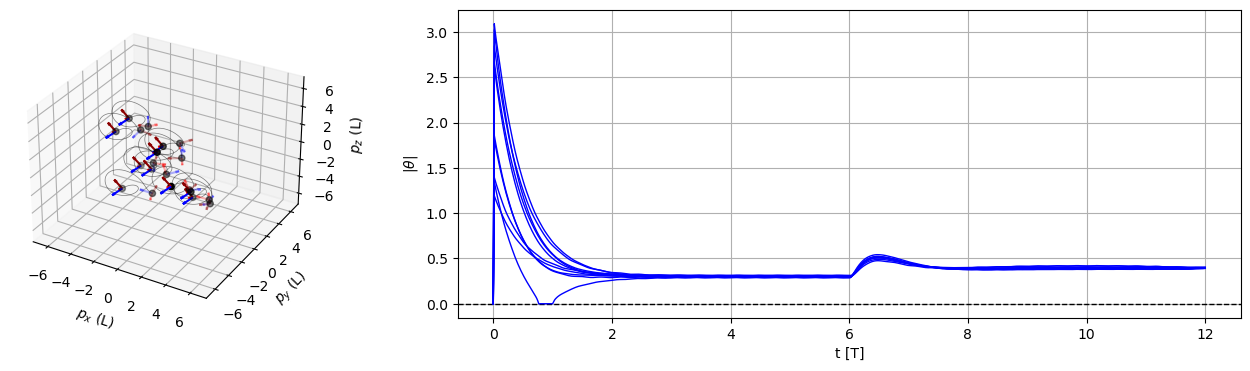

In [6]:
# Initialise the simulation frame and launch the numerical simulation
sim_frame = sim_ss(n_agents=10, tf=12, sim_kw={"kw":2}, arr_len=1)
sim_frame.numerical_simulation()

# Plot the summary (initial + final state)
sim_frame.plot_summary()

Animation parameters:  {'fps': 60.0, 'tf': 12, 'frames': 719}


100%|█████████▉| 717/719 [00:37<00:00, 21.76it/s]

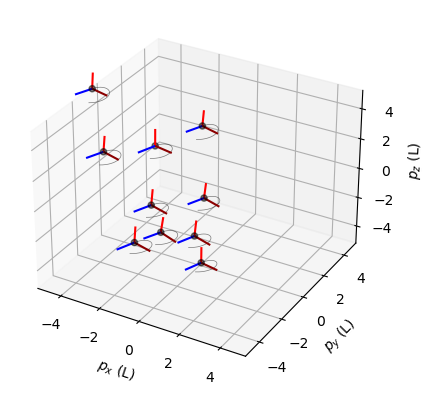

100%|█████████▉| 717/719 [00:56<00:00, 21.76it/s]

In [530]:
# Generate an animation of the whole simulation
sim_frame.generate_animation(OUTPUT_FOLDER)